In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#the following 2 lines are required if ndac is not installed
import sys
sys.path.append("..") 
import ndac

from ndac.data_processing import quantile_classify, encode_sequence, value_classify
from ndac.predict import train_clstm

/Users/joshsmith/Git/NovoNordisk_Capstone/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Raw data import
The basic raw data should be a colum of a measured experimental values to be used as a metric for classifciation (eg. expression or solubility) and a sequence (eg. amino acid or nucleotide).  The data will be imported as a pandas dataframe so more than the minimum 2 colums is acceptable.

In the example below, there are 6 columns.  The 'conc_cf' (protein experssion level) will be used as the metric and 'nt_seq' will serve as the sequence. 

In [2]:
# read in sequence/property data
data = pd.read_csv('../dataframes/DF_prest.csv', index_col=0)
data.head()

,prest_id,uniprot_id,conc_cf,aa_seq,nt_seq,aa_len
0,140095,G3V3N0,4.3075,IMTAPSSFEQFKVAMNYLQLYNVPDCLEDIQDADCSSSKCSSSASS...,GACAAGCTTGCGGCCGCAATTATGACAGCTCCCTCCAGTTTTGAGC...,139
1,140099,G3V537,2.9154,TYYAWKHELLGSGTCPALPPREVLGMEELEKLPEEQVAEEELECSA...,GACAAGCTTGCGGCCGCAACCTACTATGCCTGGAAGCATGAGCTGC...,144
2,140225,P12724,1.4877,SLHARPPQFTRAQWFAIQHISLNPPRCTIAMRAINNYRWRCKNQNT...,GACAAGCTTGCGGCCGCATCACTCCATGCCAGACCCCCACAGTTTA...,136
3,140235,H0YH02,6.7224,ARALNESKRVNNGNTAPEDSSPAKKTRRCQRQESKKMPVAGGKANK...,GACAAGCTTGCGGCCGCAGCGAGAGCATTAAATGAAAGCAAAAGAG...,123
4,140309,F5GYC5,3.3848,HRKEPGARLEATRGAARPHKQGTKPMITRPSVSQLGEGKCPSSQHL...,GACAAGCTTGCGGCCGCACATCGGAAAGAGCCTGGGGCAAGGCTGG...,124


## Data processing
Data that are labeled with an emperimental value as a metric are classified.  There are two functions available for classicication. `quntile_classify` calssifies based on the first and forth quantiles or user defined quntiles and `value_classify` classifies based on user input values for high and low values.

### `quantile_classify`
Classify low values as 0, remove middle values, and classify high values as 1.  The default is to calssify the lowest 25% of values as 0, remove the middle 50% and label the to 25% as 1.

45206 samples input.
11302 samples in class 0
11301 samples in class 1
22603 samples removed.


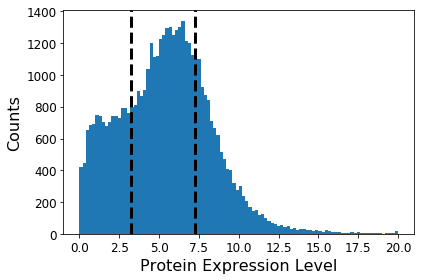

In [3]:
# split quantiles and encode with nucleotide sequence
df, hist = quantile_classify(data['conc_cf'], data['nt_seq'],
                             [0.25, 0.75], drop_class=[1])

## `value_classify`

Classify values below low_value as 0, classify values above high_value as 1 and remove values in between.


16082 samples input.
3324 samples in class 0
5091 samples in class 1
7667 samples in class 2
0 samples removed.


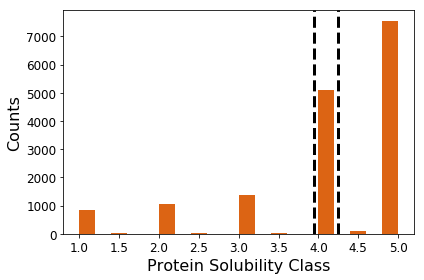

In [4]:
sol_data = pd.read_csv('../dataframes/DF_solubility.csv', index_col=0)
sol_df, sol_hist = ndac.value_classify(sol_data['solubility_class_1M'], 
                                       sol_data['aa_seq'], 
                                       split_values = [3.95,4.25])

## `encode_sequence`

Encode sequence and such..

In [5]:
X, y = encode_sequence(df['nt_seq'], df['class'],
                       max_length=200, tag='GACAAGCTTGCGGCCGCA')

## Model training

## `train_clstm`
train that clstm

In [6]:
nt_model = train_clstm(X, y, test_fraction=0.3, 
                       epochs=1)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 10)           740       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 128)          3968      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 96,409
Trainable params: 96,409
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
15677/15677 [===========================

# Want to capture our entire worflow??

here ya go:

In [ ]:
data = pd.read_csv('../dataframes/DF_prest.csv', index_col=0)
df, hist = quantile_classify(data['conc_cf'], data['nt_seq'],
                             [0.25, 0.75], drop_class=[1])
X, y = encode_sequence(df['nt_seq'], df['class'],
                       max_length=200, tag='GACAAGCTTGCGGCCGCA')
nt_model = train_clstm(X, y, test_fraction=0.3, 
                       epochs=1)

In [ ]:
# using Sastry et al. split for retrospective analysis

In [7]:
data = pd.read_csv('DF_train.csv', index_col=0)
#df, hist = quantile_classify(data['conc_cf'], data['aa_seq'], [0.25, 0.75], drop_class=[1])
X, y = encode_sequence(data['aa_seq'], data['expressed'],
                       max_length=200)
aa_model = train_clstm(X, y, epochs=35, save_file='aa_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 10)           210       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 128)          3968      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 95,879
Trainable params: 95,879
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/35
10216/10216 [==============================] - 20s 2ms/step - loss: 0.6854 - acc: 0.5459
Epoch 2/35
10216/10216 [=========